In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import seaborn as sns 
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm_notebook


from keras.models import Model
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import backend as K
from keras.layers.core import Lambda
from keras import losses

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=36ed23300d251de97ede25709363235ffa2821fb59efe8e446ec4b5fea7b769a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haridev16","key":"25745b8ef3c2b143e6f53eae0100fb34"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-07 08:06:45           2169        225  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1271        139  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            982         99  1.0              
imsparsh/musicnet-dataset                                   MusicNet Dataset              

In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

100% 1.56G/1.57G [00:16<00:00, 86.1MB/s]
100% 1.57G/1.57G [00:16<00:00, 99.2MB/s]


In [ ]:
!mkdir sheet-metal-dataset

In [ ]:
!unzip /content/severstal-steel-defect-detection.zip -d /content/sheet-metal-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/sheet-metal-dataset/train_images/99f75320d.jpg  
  inflating: /content/sheet-metal-dataset/train_images/99f9d2375.jpg  
  inflating: /content/sheet-metal-dataset/train_images/99fd3c6f5.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a016fe15.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a064450d.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a08c2783.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a18e4457.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a1f7c238.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a2523ce9.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a3e774ff.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a5e9e77c.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a5f7a855.jpg  
  inflating: /content/sheet-metal-dataset/train_images/9a62177bb.jpg  
  inflating: /content/shee

In [ ]:
df = pd.read_csv("./sheet-metal-dataset/train.csv")

In [ ]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
len(df["ImageId"].unique())

# Unique images are 6666 out of 7095

6666

In [ ]:
# Single instance of image based records

df = (df[['ImageId', 'ClassId', 'EncodedPixels']].groupby('ImageId', as_index=False).agg(list))
df['DistinctDefectTypes'] = df['ClassId'].apply(lambda x: len(x))

In [ ]:
print(df.shape)

(6666, 4)


In [ ]:
df.head()

,ImageId,ClassId,EncodedPixels,DistinctDefectTypes
0,0002cc93b.jpg,[1],[29102 12 29346 24 29602 24 29858 24 30114 24 ...,1
1,0007a71bf.jpg,[3],[18661 28 18863 82 19091 110 19347 110 19603 1...,1
2,000a4bcdd.jpg,[1],[37607 3 37858 8 38108 14 38359 20 38610 25 38...,1
3,000f6bf48.jpg,[4],[131973 1 132228 4 132483 6 132738 8 132993 11...,1
4,0014fce06.jpg,[3],[229501 11 229741 33 229981 55 230221 77 23046...,1


In [ ]:
sum(df["EncodedPixels"].isna())

# Every record has a mask in the dataset

0

## class distribution

{1: 897, 2: 247, 3: 5150, 4: 801}

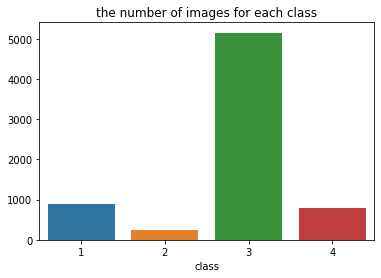

In [ ]:
classes = {1:0,2:0,3:0,4:0}
for r in df["ClassId"]:
  for i in r:
    classes[i]+=1

fig, ax = plt.subplots()
sns.barplot(x=list(classes.keys()), y=list(classes.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
classes

In [ ]:
d = {}
for i in range(4):
  d[i+1] = sum(df["DistinctDefectTypes"] > i)

{1: 6666, 2: 427, 3: 2, 4: 0}


Text(0.5, 1.0, 'Class distribution per image')

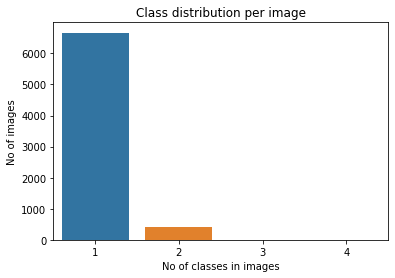

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=list(d.keys()), y=list(d.values()), ax=ax)
ax.set_xlabel("No of classes in images")
ax.set_ylabel("No of images")
print(d)
ax.set_title("Class distribution per image")

# STATS

In [ ]:
train_img_total = 0
train_path = Path("./sheet-metal-dataset/train_images/")
for img_name in train_path.iterdir():
  train_img_total+=1

In [ ]:
print("Total training images are", train_img_total)
print("Out of 12568 training images, 7095 have labels")
print("From 7095 training images, 6666 are unique")

Total training images are 12568
Out of 12568 training images, 7095 have labels
From 7095 training images, 6666 are unique


In [ ]:
test_img_total = 0
test_path = Path("./sheet-metal-dataset/test_images/")
for img_name in test_path.iterdir():
  test_img_total+=1

In [ ]:
print("Total testing images are", test_img_total)


Total testing images are 5506


PREVIEWING AN IMAGE

0030401a5.jpg


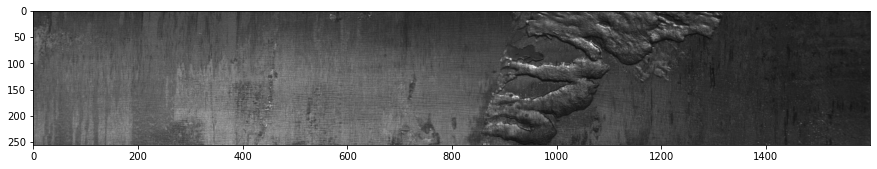

In [ ]:
img_name = df["ImageId"][8]
img_enocding = df["EncodedPixels"][8]
img_class = df["ClassId"][8]
img = cv2.imread(str(train_path/img_name))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
print(img_name)

## MASK VISUALIZATION

In [ ]:
#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_arr, class_list):
  mask = np.zeros((256,1600,4),dtype=np.uint8)
  for i in range(len(class_list)):
    c = class_list[i]
    rle = np.array([int(s)for s in rle_arr[i].split(" ")])
    starts_array = rle[::2]-1
    lengths_array = rle[1::2]
    mask_array = np.zeros(256*1600,dtype=np.uint8)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1    
    mask[:,:,c-1] = mask_array.reshape((256,1600), order = 'F')
  return mask

In [ ]:
#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

In [ ]:
mask = rle2mask(img_enocding, img_class)

In [ ]:
color_palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [ ]:
for i in img_class:
  contours, _ = cv2.findContours(mask[:,:,i-1], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  for j in range(0, len(contours)):
      cv2.polylines(img, contours[j], True, color_palet[i-1], 2)

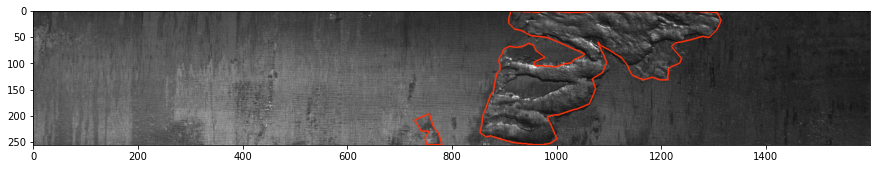

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)

In [ ]:
df_train = df[:-1650]
df_val = df[-1650:]
print(df_train.shape, df_val.shape)

(5016, 4) (1650, 4)


In [ ]:
def train_keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId'].iloc[i]
            img = cv2.imread( './sheet-metal-dataset/train_images/'+fn )
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], df_train["ClassId"].iloc[i])
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

def val_keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_val['ImageId'].iloc[i]
            img = cv2.imread( './sheet-metal-dataset/train_images/'+fn )
            
            mask = rle2mask(df_val['EncodedPixels'].iloc[i], df_val["ClassId"].iloc[i])
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

# MODEL

In [ ]:
smooth=1
def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

In [ ]:
#Model

inputs = Input((256, 1600, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
%%time
# Fit model
batch_size = 16
results = model.fit(train_keras_generator(batch_size),validation_data=val_keras_generator(batch_size), steps_per_epoch=100,epochs=20) 

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0478 - dice_coef: 0.3879

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(x)

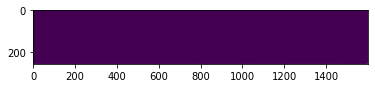

In [ ]:
plt.imshow(np.squeeze(pred[3]))

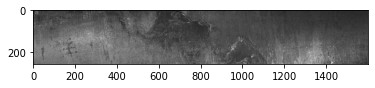

In [ ]:
plt.imshow(x[3])

In [ ]:
testfiles=os.listdir("./sheet-metal-dataset/test_images/")
len(testfiles)

5506

In [ ]:
%%time
test_img = []
for fn in tqdm_notebook(testfiles):
        img = cv2.imread( './sheet-metal-dataset/test_images/'+fn )
        test_img.append(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 33 s, sys: 3.4 s, total: 36.4 s
Wall time: 38.9 s


In [ ]:
%%time
predict = model.predict(np.asarray(test_img))
print(len(predict))

In [ ]:
img_t = cv2.imread( './sheet-metal-dataset/test_images/'+ testfiles[4])
plt.imshow(img_t)

In [ ]:
plt.imshow(predict[4])

In [ ]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()